# Dask Geohash Sorted

In [1]:
import time
from pathlib import Path

import geopandas
import dask_geopandas

import dask.dataframe as dd
from distributed import LocalCluster, Client

In [2]:
# set up data paths
base_path = Path().cwd().parent.parent
data_dir = base_path.joinpath('data')

In [3]:
# create local dask cluster
cluster = LocalCluster(#silence_logs=logging.ERROR,
                       dashboard_address=':8790',
                       n_workers=1,
                       threads_per_worker=4,
                       memory_limit='4 GB')
client = Client(cluster)
client

/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8790 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40697 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37325 Dashboard: http://127.0.0.1:40697/status,Cluster Workers: 1 Cores: 4 Memory: 3.73 GiB


In [4]:
# load spatially sorted us data
spatial_sort_path = data_dir.joinpath('us_cont_spatiallysorted_geopandas.parquet')
df = dask_geopandas.read_parquet(spatial_sort_path)
df

,latitude,longitude,geometry
npartitions=1218,,,
25629,float64,float64,geometry
51981109,...,...,...
...,...,...,...
1027558833,...,...,...
1073720176,...,...,...


In [5]:
df.head(2)

,latitude,longitude,geometry
hilbert_distance,,,
25629,24.447,-124.443,POINT (-124.44300 24.44700)
99850,24.704,-124.532,POINT (-124.53200 24.70400)


In [6]:
len_df = len(df)
len_df

113944489

<AxesSubplot:>

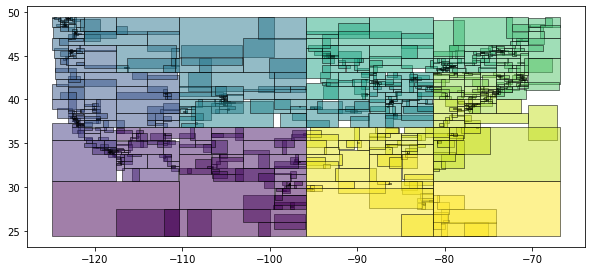

In [7]:
df.spatial_partitions.plot(cmap="viridis", alpha=0.5, edgecolor="k", figsize=(10, 6))

In [8]:
# load various size subsets of the zip code data as spatialpandas.geodataframes
zips_1 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_1.geojson')).loc[:, ['geometry']]
zips_10 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_10.geojson')).loc[:, ['geometry']]
zips_100 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_100.geojson')).loc[:, ['geometry']]
zips_1000 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_1000.geojson')).loc[:, ['geometry']]
zips_10000 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_10000.geojson')).loc[:, ['geometry']]

In [9]:
zips_1.crs = None
zips_10.crs = None
zips_100.crs = None
zips_1000.crs = None
zips_10000.crs = None

In [10]:
zips_1 = dask_geopandas.from_geopandas(zips_1, npartitions=1)
zips_1.calculate_spatial_partitions()
zips_10 = dask_geopandas.from_geopandas(zips_10, npartitions=1)
zips_10.calculate_spatial_partitions()
zips_100 = dask_geopandas.from_geopandas(zips_100, npartitions=1)
zips_100.calculate_spatial_partitions()
zips_1000 = dask_geopandas.from_geopandas(zips_1000, npartitions=1)
zips_1000.calculate_spatial_partitions()
zips_10000 = dask_geopandas.from_geopandas(zips_10000, npartitions=1)
zips_10000.calculate_spatial_partitions()

In [11]:
%%time
total_points = len_df
num_partitions = df.npartitions
num_polygons = []
time_sec = []
num_result_points = []
num_points = len_df

t00 = time.time()
for zip_gdf in [zips_1, zips_10, zips_100, zips_1000, zips_10000]:
    num_polygons.append(len(zip_gdf))
    t0 = time.time()
    
    rdf = dask_geopandas.sjoin(df, zip_gdf, how='inner').compute()

    time_sec.append(time.time() - t0)
    num_result_points.append(len(rdf))
    print(f'num_polygons[-1]: {num_polygons[-1]}, time_sec[-1]: {time_sec[-1]:.0f} s')

num_polygons[-1]: 1, time_sec[-1]: 0 s
num_polygons[-1]: 10, time_sec[-1]: 68 s
num_polygons[-1]: 100, time_sec[-1]: 132 s
num_polygons[-1]: 1000, time_sec[-1]: 188 s


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


The default (convex hull) spatial partitions are not helping much (they quickly cover the full of the US), can overcome this with making them more detailed:

In [27]:
zips_100.spatial_partitions = geopandas.GeoSeries([zips_100.envelope.unary_union.compute()])

In [29]:
%time dask_geopandas.sjoin(df, zips_100, how='inner').compute()

CPU times: user 11.1 s, sys: 580 ms, total: 11.7 s
Wall time: 41.7 s


,latitude,longitude,geometry,index_right
hilbert_distance,,,,
109588164,29.521233,-98.395233,POINT (-98.39523 29.52123),37
109588164,29.521226,-98.395203,POINT (-98.39520 29.52123),37
109588164,29.520835,-98.395928,POINT (-98.39593 29.52084),37
109588164,29.521110,-98.395433,POINT (-98.39543 29.52111),37
109588164,29.521378,-98.395220,POINT (-98.39522 29.52138),37
...,...,...,...,...
1027844778,29.081709,-80.923393,POINT (-80.92339 29.08171),99
1027844778,29.081762,-80.923400,POINT (-80.92340 29.08176),99
1027844778,29.081759,-80.923412,POINT (-80.92341 29.08176),99


This results in 41s instead of 132s in the example above.

In [ ]:
# save summary info to file
results_df = pd.DataFrame({'num_polygons': num_polygons,
                           'num_points': num_points,
                           'num_result_points': num_result_points,
                           'time_min': np.asarray(time_sec)/60})                      
results_df.to_csv(f'spatially_sorted_results_{datetime.now()}.csv')
results_df

In [ ]:
# release the dask workers
cluster.scale(0)

In [10]:
client.shutdown()